#### 1.0 Importing Dependencies:

In [46]:
# Importing dependencies:
import pandas as pd
import numpy as np
import math
from scipy import stats

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Set custom preferences for displaying and visualizing data
# sns.set_style('white')
pd.set_option('max_colwidth', 120)
pd.set_option('max_columns', 200)
pd.set_option('precision', 2)
plt.rcParams["figure.figsize"] = (10, 7.5)

%matplotlib inline

#### 2.0 Applied Machine Leaning:

#### 2.1 Loading Datasets:

In [2]:
df = pd.read_csv('data/clean_demographic_transaction.csv')
df.head()

//anaconda3/envs/Springboard/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,household_key,basket_id,day,product_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,customer_price,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,1364,26984896261,1,842930,1,2.19,31742,0.00,1520,1,0.0,0.0,2.19,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown
1,1364,26984896261,1,897044,1,2.99,31742,-0.40,1520,1,0.0,0.0,2.99,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown
2,1364,26984896261,1,920955,1,3.09,31742,0.00,1520,1,0.0,0.0,3.09,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown
3,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,0.0,0.0,2.50,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown
4,1364,26984896261,1,981760,1,0.60,31742,-0.79,1520,1,0.0,0.0,0.60,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown


#### 2.2 Getting Top 10 Products:

In [3]:
top_10 = df['product_id'].value_counts().index
top_10 = top_10[:10]
top_10

Int64Index([1082185, 6534178, 1029743,  995242,  981760, 1106523, 1133018,
             951590, 1127831,  883404],
           dtype='int64')

In [4]:
df_top_10 = df.loc[df['product_id'].isin(top_10)]
df_top_10 = df_top_10.groupby(['household_key', 'product_id']).size().reset_index(name='count')
df_top_10.head()

,household_key,product_id,count
0,1,995242,35
1,1,1029743,2
2,1,1082185,41
3,7,995242,1
4,7,1029743,2


In [6]:
df_sorted = df.groupby(['household_key', 'product_id']).size().reset_index(name='count').sort_values('household_key')
df_sorted.head()

,household_key,product_id,count
0,1,819312,1
444,1,1111870,3
445,1,1112333,1
446,1,1113385,1
447,1,1115576,3


In [7]:
df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700879 entries, 0 to 700878
Data columns (total 3 columns):
household_key    700879 non-null int64
product_id       700879 non-null int64
count            700879 non-null int64
dtypes: int64(3)
memory usage: 21.4 MB


#### 2.3 Creating Dummy Results:

In [8]:
basket = (df_sorted.groupby(['household_key', 'product_id'])['count'].sum().unstack().reset_index().fillna(0).set_index('household_key'))
basket.head()

product_id,25671,26601,26636,26738,27021,27158,27334,27346,27479,27491,27503,27509,27522,27658,27686,27732,27735,27745,27754,27760,27812,27894,27933,27951,27958,28041,28143,28165,28200,28219,28267,28268,28272,28326,28424,28453,28897,28929,28966,29618,29629,29936,29977,29989,30177,30295,30317,30339,30356,30374,30613,30699,30800,30962,31159,31349,31534,31681,31704,32124,32160,32243,32247,32369,32384,32387,32392,32439,32440,32454,32456,32457,32482,32553,32562,32608,32785,32916,32987,33247,33345,33401,33522,33555,33592,33614,33882,33965,34039,34138,34145,34160,34187,34204,34233,34269,34345,34349,34359,34480,...,18105562,18105641,18106059,18106104,18106138,18106229,18106248,18106258,18106286,18106415,18106655,18106670,18106701,18106818,18106881,18107080,18107092,18107212,18107220,18107265,18107345,18107424,18118865,18118972,18118989,18119004,18119016,18119460,18119463,18119475,18119592,18119983,18120172,18120486,18120821,18120904,18127762,18131707,18131909,18143349,18147269,18147457,18147510,18147540,18147572,18147612,18147773,18147946,18148096,18148128,18148208,18148439,18148441,18148533,18148536,18148548,18148596,18148632,18148654,18148676,18148708,18148726,18148794,18148806,18148815,18148870,18183625,18183737,18183744,18183776,18184178,18184179,18184230,18185083,18185268,18185306,18185750,18185766,18186504,18186729,18189027,18192496,18192639,18203504,18203921,18204200,18205871,18206211,18243471,18243476,18243940,18244314,18244317,18244453,18253088,18273115,18292005,18293696,18294080,18316298
household_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

#### 2.4 Encoder Formula:

In [9]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

#### 2.5 Encoding Baskets:

In [10]:
encoded_baskets = basket.applymap(encode_units)
encoded_baskets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 801 entries, 1 to 2499
Columns: 67902 entries, 25671 to 18316298
dtypes: int64(67902)
memory usage: 415.0 MB


#### 2.6 Finding Consequents and Antecendents:

In [11]:
frequent_itemsets = apriori(encoded_baskets, min_support=0.25, use_colnames=True)

In [12]:
rules = pd.DataFrame(association_rules(frequent_itemsets, metric="lift", min_threshold=1))
rules.sort_values("lift", ascending=False, inplace=True)
rules.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
166101,"(1133018, 1098066)","(981760, 1106523)",0.36,0.38,0.25,0.69,1.85,0.12,2.04
166100,"(981760, 1106523)","(1133018, 1098066)",0.38,0.36,0.25,0.67,1.85,0.12,1.94
292943,"(1133018, 1082185, 1004906)","(981760, 1106523)",0.36,0.38,0.25,0.69,1.84,0.11,2.03
292950,"(981760, 1106523)","(1133018, 1082185, 1004906)",0.38,0.36,0.25,0.67,1.84,0.11,1.92
292939,"(981760, 1082185, 1106523)","(1133018, 1004906)",0.37,0.37,0.25,0.68,1.84,0.11,1.98
292954,"(1133018, 1004906)","(981760, 1082185, 1106523)",0.37,0.37,0.25,0.68,1.84,0.11,1.97
292940,"(981760, 1133018, 1004906)","(1082185, 1106523)",0.33,0.42,0.25,0.76,1.83,0.11,2.45
292953,"(1082185, 1106523)","(981760, 1133018, 1004906)",0.42,0.33,0.25,0.60,1.83,0.11,1.69
292949,"(981760, 1133018)","(1082185, 1004906, 1106523)",0.43,0.32,0.25,0.58,1.83,0.11,1.64
292944,"(1082185, 1004906, 1106523)","(981760, 1133018)",0.32,0.43,0.25,0.79,1.83,0.11,2.66


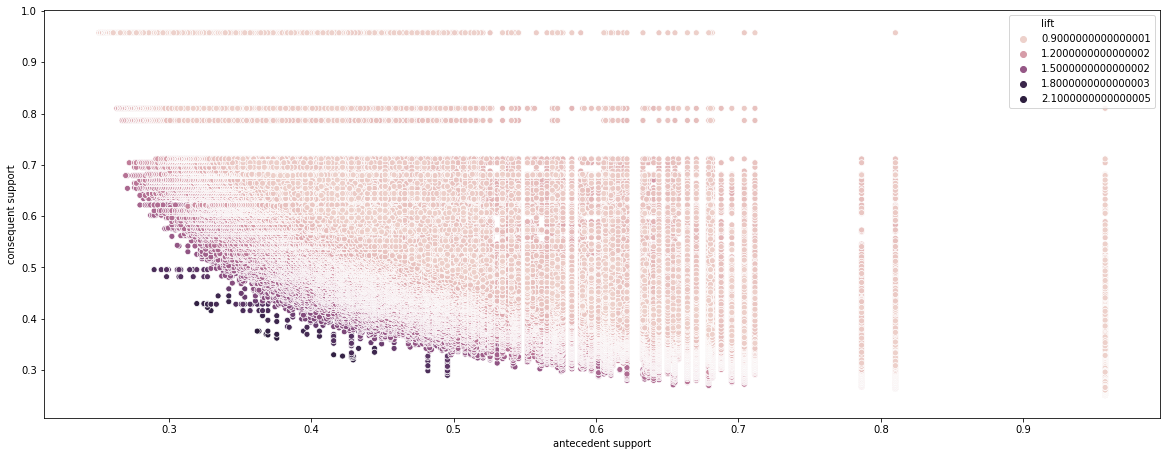

In [39]:
plt.figure(figsize=(20, 7.5))

sns.scatterplot('antecedent support', 'consequent support', data=rules, hue='lift')

plt.show()

#### 2.7 Train Test Model:

In [22]:
def train_test_model(X, y, model, params, test_size=.2, random_state=42):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    model_cv = GridSearchCV(model, param_grid=params, cv=5)
    
    model_cv.fit(X_train, y_train)
    
    y_pred = model_cv.predict(X_test)
    
    y_pred_prob = model_cv.predict_proba(X_test)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show();
    
    # Print the optimal parameters and best score
    print("Tuned Hyperparameter(s): {}".format(model_cv.best_params_))
    print("Tuned Accuracy Score: {}".format(model_cv.best_score_))
    print(classification_report(y_test, y_pred))

In [59]:
# df_rules = [list(x) for x in rules]
df_rules = pd.DataFrame(rules)
df_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
166101,"(1133018, 1098066)","(981760, 1106523)",0.36,0.38,0.25,0.69,1.85,0.12,2.04
166100,"(981760, 1106523)","(1133018, 1098066)",0.38,0.36,0.25,0.67,1.85,0.12,1.94
292943,"(1133018, 1082185, 1004906)","(981760, 1106523)",0.36,0.38,0.25,0.69,1.84,0.11,2.03
292950,"(981760, 1106523)","(1133018, 1082185, 1004906)",0.38,0.36,0.25,0.67,1.84,0.11,1.92
292939,"(981760, 1082185, 1106523)","(1133018, 1004906)",0.37,0.37,0.25,0.68,1.84,0.11,1.98


In [55]:
df_rules.isnull().sum()

antecedents           0
consequents           0
antecedent support    0
consequent support    0
support               0
confidence            0
lift                  0
leverage              0
conviction            0
dtype: int64

In [51]:
X = rules.drop(['lift', 'antecedents', 'consequents'], axis=1).values.round(2)
y = rules['lift'].values.round(2)
print(X.shape, y.shape)

(314234, 6) (314234,)


In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=42, shuffle=True)

#### 2.8 KMean:

In [53]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0, verbose=0)
kmeans.fit(X_train, y_train)
kmeans.score(X_test, y_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Do not include the households with 'unknown' values for some demographic features
# c = (df_hh_demographic['MARITAL_STATUS_CODE'] != 'U') & \
#     (df_hh_demographic['HH_COMP_DESC'] != 'Unknown') & \
#     (df_hh_demographic['HOMEOWNER_DESC'] != 'Unknown') & \
#     (df_hh_demographic['KID_CATEGORY_DESC'] != 'None/Unknown')

# Set number of clusters
k = 10

# One-hot encode categorical demographic features
X = pd.get_dummies(df_ml)

# Use PCA to project the demographic data into 2 dimensions
pca = PCA(n_components=2).fit(X)
X_proj = pca.transform(X)

# Cluster the 2D data using K-means
kmeans = KMeans(n_clusters=k).fit(X_proj)
labels = kmeans.labels_.reshape(-1, 1) + 1

df_ml_clustered = pd.DataFrame(np.concatenate((X_proj, labels), axis=1), columns=['Principal Component 1', 'Principal Component 2', 'Cluster'])
df_ml_clustered['Cluster'] = df_ml_clustered['Cluster'].astype(int)

f, ax = plt.subplots(figsize=(14, 12))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2',  data=df_ml_clustered, hue='Cluster', palette=sns.color_palette('muted', n_colors=k))
plt.show()

In [ ]:
df_ml_clustered.head()

In [ ]:
df['Cluster'] = labels

print(df_ml_clustered[df_ml_clustered['Cluster'] == 1]['-627887.06'].value_counts())
# print()
# print(df_ml_clustered[df_ml_clustered['Cluster'] == 2]['HOUSEHOLD_SIZE_DESC'].value_counts())
# print()
# print(df_ml_clustered[df_ml_clustered['Cluster'] == 3]['HOUSEHOLD_SIZE_DESC'].value_counts())